- Data: clean dataset where missing data was replaced with 'missing'. No imputing.
- Approach: 
    - combine item description, brand and name into a single text feature.
    - encode text features using TfidfVectorizer.
    - encode brand and categories using OHE
- Models:
    - Ridge Regressor
    - LightGBM
    - SGD
- Evaluation metrics:
    - RMSLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, OrdinalEncoder, StandardScaler
from scipy.sparse import hstack, save_npz
from IPython.display import Markdown

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style

#### Utils

In [3]:
def get_pred_price(log_price):
    return np.exp(log_price)-1

def normalize_text(text):
    '''
    Handles diacritic marks, superscripts and subscripts.
    Returns the text in lowercase.
    '''
    text = text.replace('–', '-').strip()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8").lower()
    return text

def pre_process_brand(text):
    clean_text = normalize_text(text).replace(' ', '_')
    #clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    return clean_text

def pre_process_category(text):
    clean_text = normalize_text(text)
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text).replace(' ', '_')
    return clean_text

def pred_vs_actual(pred, actual):
    fig, ax = plt.subplots(figsize=(10,6), gridspec_kw={'hspace': 0.3})
    x = range(len(actual))

    ax.plot(x, actual, label='Actual values')
    ax.plot(x, pred, label='Predicted values')
    ax.legend(loc=1, bbox_to_anchor=(0.75, 0, 0.5, 1))
    plt.show()

___

In [4]:
data_path = 'data/'
data_file_name = 'mercari_eda_cleaned.csv'
data_full_path = data_path + data_file_name

product_listings_mercari = pd.read_csv(data_full_path, keep_default_na=False)
display(product_listings_mercari.shape)
product_listings_mercari.head()

(1481661, 12)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity


In [5]:
product_listings_mercari['brand_name'] = product_listings_mercari['brand_name'].apply(pre_process_brand)
product_listings_mercari['main_cat'] = product_listings_mercari['main_cat'].apply(pre_process_category)
product_listings_mercari['sub_cat1'] = product_listings_mercari['sub_cat1'].apply(pre_process_category)
product_listings_mercari['sub_cat2'] = product_listings_mercari['sub_cat2'].apply(pre_process_category)

# combining name, item_description, and brand in a single column ('text')
product_listings_mercari.replace('missing', '', inplace=True)
product_listings_mercari['name_comb'] = product_listings_mercari['preprocessed_name'] + ' ' + product_listings_mercari['brand_name']

product_listings_mercari['text'] = product_listings_mercari['preprocessed_name'] + ' ' + product_listings_mercari['preprocessed_description'] + ' ' + product_listings_mercari['main_cat'] + ' ' + product_listings_mercari['sub_cat1'] + ' ' + product_listings_mercari['sub_cat2']

product_listings_mercari['log_price'] = np.log1p(product_listings_mercari['price'].values.astype(np.float32))

In [6]:
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,name_comb,text,log_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,,10.0,1,No description yet,men,tops,t_shirts,mlb cincinnati reds shirt size xl,description yet,mlb cincinnati reds shirt size xl,mlb cincinnati reds shirt size xl description ...,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers_tablets,components_parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...,razer blackwidow chroma keyboard razer,razer blackwidow chroma keyboard keyboard grea...,3.970292
2,2,AVA-VIV Blouse,1,target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops_blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...,ava viv blouse target,ava viv blouse adorable top hint lace key hole...,2.397895
3,3,Leather Horse Statues,1,,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home_decor,home_decor_accents,leather horse statues,new tags leather horses retail stand foot high...,leather horse statues,leather horse statues new tags leather horses ...,3.583519
4,4,24K GOLD plated rose,1,,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity,24k gold plated rose,24k gold plated rose complete certificate auth...,3.806663


#### Splitting data

In [7]:
features = ['name_comb', 'text','item_condition_id', 'shipping']
X, y = product_listings_mercari[features], product_listings_mercari['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1185328, 4), (296333, 4))

In [8]:
X_train.head()

,name_comb,text,item_condition_id,shipping
1142652,brand new skull candy headphones,brand new skull candy headphones never used el...,2,0
1142448,lularoe bow leggings new blue purple os lularoe,lularoe bow leggings new blue purple os brand ...,2,0
220982,sarah deaden teen love books,sarah deaden teen love books free shipping neg...,2,1
479456,authentic harry potter hermione wand,authentic harry potter hermione wand hermione ...,1,1
1299063,victoria secret victoria's_secret,victoria secret 34a victoria secret aerie bra ...,3,0


In [9]:
# ohe for shipping and item_condition

# item condition
ohe_cond = OneHotEncoder(handle_unknown="ignore")
ohe_cond.fit(product_listings_mercari.item_condition_id.values.reshape(-1,1))

tr_cond_ohe = ohe_cond.transform(X_train.item_condition_id.values.reshape(-1,1))
val_cond_ohe = ohe_cond.transform(X_test.item_condition_id.values.reshape(-1,1))

# shipping
ohe_ship = OneHotEncoder(handle_unknown="ignore")
ohe_ship.fit(product_listings_mercari.shipping.values.reshape(-1,1))

tr_ship_ohe = ohe_ship.transform(X_train.shipping.values.reshape(-1,1))
val_ship_ohe = ohe_ship.transform(X_test.shipping.values.reshape(-1,1))

tr_cond_ohe.shape, val_cond_ohe.shape, tr_ship_ohe.shape, val_ship_ohe.shape

((1185328, 5), (296333, 5), (1185328, 2), (296333, 2))

In [11]:
# vectorizing name+brand (brand_comb)
tfidf_name = TfidfVectorizer(max_features=50000)
tfidf_name.fit(X_train.name_comb)

tr_vec_name = tfidf_name.transform(X_train.name_comb)
val_vec_name = tfidf_name.transform(X_test.name_comb)

tr_vec_name.shape, val_vec_name.shape

((1185328, 50000), (296333, 50000))

In [12]:
# vectorizing text
tfidf_text = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
tfidf_text.fit(X_train.text)

tr_vec_text = tfidf_text.transform(X_train.text)
val_vec_text = tfidf_text.transform(X_test.text)

tr_vec_text.shape, val_vec_text.shape

((1185328, 50000), (296333, 50000))

<u>Stacking all features</u>

In [13]:
x_train = hstack((tr_vec_name, tr_vec_text, tr_cond_ohe, tr_ship_ohe))
x_train.shape

(1185328, 100007)

In [14]:
x_val = hstack((val_vec_name, val_vec_text, val_cond_ohe, val_ship_ohe))
x_val.shape

(296333, 100007)

#### Ridge

#### Execution Time - Training

CPU times: user 29.3 s, sys: 913 ms, total: 30.2 s
Wall time: 40.4 s


#### Execution Time - Prediction

CPU times: user 44.2 ms, sys: 2.5 ms, total: 46.6 ms
Wall time: 43.8 ms


#### Model in Test Data

R2: 0.6319
RMSLE: 0.4523


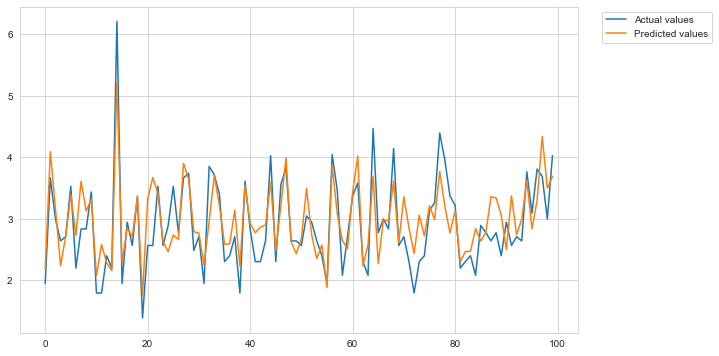

In [15]:
ridge_best = Ridge(alpha=1)
display(Markdown("#### Execution Time - Training"))
%time ridge_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = ridge_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### LightGBM

#### Execution Time - Training

CPU times: user 40min 13s, sys: 1min 12s, total: 41min 25s
Wall time: 12min 6s


#### Execution Time - Prediction

CPU times: user 34.6 s, sys: 151 ms, total: 34.8 s
Wall time: 7.05 s


#### Model in Test Data

R2: 0.6175
RMSLE: 0.4610


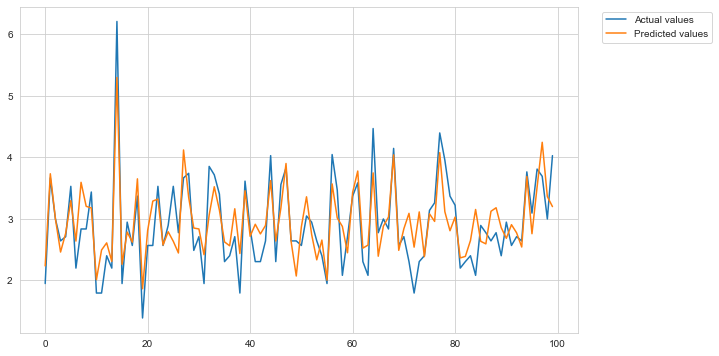

In [16]:
lgb_best = LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=500, reg_alpha=1.5)

display(Markdown("#### Execution Time - Training"))
%time lgb_best.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = lgb_best.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

#### SGD

#### Execution Time - Training

CPU times: user 9.57 s, sys: 235 ms, total: 9.81 s
Wall time: 9.05 s


#### Execution Time - Prediction

CPU times: user 726 ms, sys: 207 ms, total: 933 ms
Wall time: 309 ms


#### Model in Test Data

R2: 0.5393
RMSLE: 0.5060


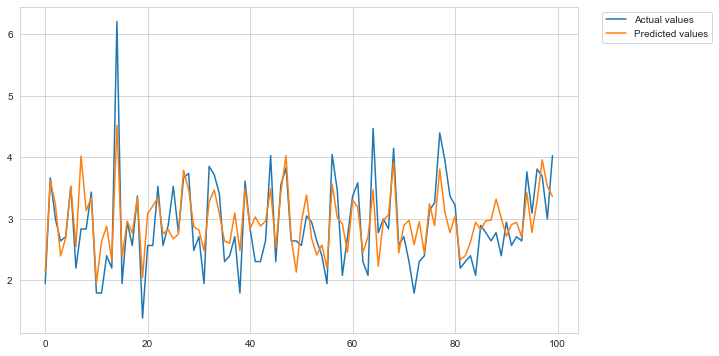

In [17]:
sgd = SGDRegressor(alpha=0.00001)

display(Markdown("#### Execution Time - Training"))
%time sgd.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = sgd.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

___

#### Stacking Regressor

#### Execution Time - Training

CPU times: user 3h 2min 42s, sys: 5min 38s, total: 3h 8min 21s
Wall time: 29min 19s


#### Execution Time - Prediction

CPU times: user 37.2 s, sys: 383 ms, total: 37.6 s
Wall time: 5.06 s


#### Model in Test Data

R2: 0.6548
RMSLE: 0.4380


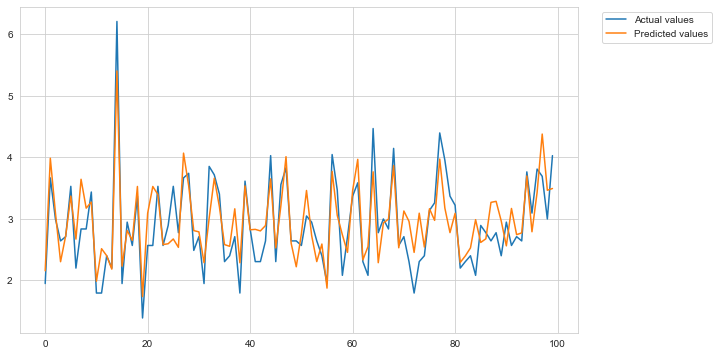

In [18]:
from sklearn.ensemble import StackingRegressor

estimators = [('ridge',  Ridge(alpha=1)), 
              ('lgb', LGBMRegressor(random_state=42, learning_rate=0.3, max_depth=9, n_estimators=500, reg_alpha=1.5))]

reg = StackingRegressor(estimators=estimators) # The default regressor is a RidgeCV.

display(Markdown("#### Execution Time - Training"))
%time reg.fit(x_train, y_train)

display(Markdown("#### Execution Time - Prediction"))
%time predicted_Y_test = reg.predict(x_val)

display(Markdown("#### Model in Test Data"))
# metrics
r2_test = metrics.r2_score(y_test, predicted_Y_test)
rmsle = np.sqrt(metrics.mean_squared_error(y_test , predicted_Y_test))
print('R2:', '{:.4f}'.format(r2_test))
print('RMSLE:', '{:.4f}'.format(rmsle))

# plotting results
pred_vs_actual(predicted_Y_test[:100], y_test[:100])

In [25]:
# MAE
actual_price = get_pred_price(y_test)
predicted_price = get_pred_price(predicted_Y_test)

mae = metrics.mean_absolute_error(actual_price, predicted_price)
mae

9.844588585134506

___

Summary:

| **Model**                          | **Notes**                                                                                         | **RMSLE** |
|:-----------------------------------|:--------------------------------------------------------------------------------------------------|:----------|
| Ridge                              | Included text features. Name+brand and Name+description+categories. Encoded with TfidfVectorizer. | 0.4520    |
| LightGBM                           | Included text features. Name+brand and Name+description+categories. Encoded with TfidfVectorizer. | 0.4610    |
| SGD                                | Included text features. Name+brand and Name+description+categories. Encoded with TfidfVectorizer. | 0.5060    |
| Stacking Regressor (meta: RidgeCV) | Included text features. Name+brand and Name+description+categories. Encoded with TfidfVectorizer. | <font color='red'>0.4380</font>    |

In [20]:
# exporting models and objects of interest
from pickle import dump

models_path = 'models/'

# encoders
dump(ohe_cond, open(models_path + 'ohe_condition.pkl', 'wb'))
dump(ohe_ship, open(models_path + 'ohe_shiping.pkl', 'wb'))
dump(tfidf_name, open(models_path + 'tfidf_name.pkl', 'wb'))
dump(tfidf_text, open(models_path + 'tfidf_text.pkl', 'wb'))

# ridge
dump(ridge_best, open(models_path + 'ridge.pkl', 'wb'))
# lightgbm
dump(lgb_best, open(models_path + 'lgb.pkl', 'wb'))

# stacking regressor
dump(reg, open(models_path + 'stack_regressor.pkl', 'wb'))

In [23]:
# encoded data
from scipy.sparse import save_npz
# sparse matrixes
save_npz(data_path + 'train_sparse_matrix.npz', x_train)
save_npz(data_path + 'test_sparse_matrix.npz', x_val)

# y values (pd.Series)
y_train.to_csv(data_path + "y_train.csv", index=False)
y_test.to_csv(data_path + "y_test.csv", index=False)